In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 0
    
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

import os
import sys
import uuid
import time
import copy

#lets find databe.py
modulepath = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.abspath(os.path.join(modulepath)))

from simple_graph_db import Database

06:00:37 DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Autosave disabled


In [2]:
class Node():
    def __init__(self, name="N.N."):
        self.name = name
        self.uuid = uuid.uuid4().hex
        self.parent = None

    def copy(self, name=None):
        new_node = copy.deepcopy(self)
        new_node.uuid = uuid.uuid4().hex
        new_node.parent = self.uuid
        if name is not None:
            new_node.name = name
        return new_node

    @property
    def data(self):
        return {"name":self.name,
                "uuid":self.uuid,
                "!parent":self.parent}

    def __str__(self):
        return "{0.name}:{0.uuid}".format(self)

    __repr__ = __str__

In [3]:
nodes = []

n0 = Node("n0")
n01 = n0.copy("n01")
n02 = n0.copy("n02")
n011 = n01.copy("n011")
n012 = n01.copy("n012")
print(n0)
print(n01)
nodes.extend([n0, n01, n02, n011, n012])
print(nodes)

n0:8d84a566cb29474b8ea4ff90a749d32d
n01:4e021ca3828846a09ddbb06434af4405
[n0:8d84a566cb29474b8ea4ff90a749d32d, n01:4e021ca3828846a09ddbb06434af4405, n02:12cc252ed36d4943a104495da6a47371, n011:85583daedbba4545be16287379f75c8d, n012:2c112be6c9ab4be2a5591e088ef74689]


## initialize db

In [4]:

db_file = "/tmp/simple_graph_database.sqlite"
if os.path.exists(db_file):
    os.remove(db_file)

db = Database(db_file=db_file)
print(db)

db.add_node(data={"a":1}, identifier=None)

(DB:'/tmp/simple_graph_database.sqlite')


'c5e9b78db4c04bc68bc5ded2869078e1'

## add nodes

In [5]:
for node in nodes:
    db.add_node(identifier=node.uuid, data=node.data)

In [6]:
db.find_node(node.uuid)

{'name': 'n012',
 'uuid': '2c112be6c9ab4be2a5591e088ef74689',
 '!parent': '4e021ca3828846a09ddbb06434af4405',
 'id': '2c112be6c9ab4be2a5591e088ef74689'}

## add edges

In [7]:
for node in nodes:
    if node.parent is not None and node.uuid is not None:
        print("{} -> {}".format(node.parent, node.uuid))
        db.connect_nodes(node.parent, node.uuid, {'parent': node.parent})


8d84a566cb29474b8ea4ff90a749d32d -> 4e021ca3828846a09ddbb06434af4405
8d84a566cb29474b8ea4ff90a749d32d -> 12cc252ed36d4943a104495da6a47371
4e021ca3828846a09ddbb06434af4405 -> 85583daedbba4545be16287379f75c8d
4e021ca3828846a09ddbb06434af4405 -> 2c112be6c9ab4be2a5591e088ef74689


## get node by uuid

In [8]:
rn0 = db.find_node(n0.uuid)
print(rn0)
assert n0.uuid == rn0.get("uuid")

{'name': 'n0', 'uuid': '8d84a566cb29474b8ea4ff90a749d32d', '!parent': None, 'id': '8d84a566cb29474b8ea4ff90a749d32d'}


## get all nodes

In [9]:
db.find_nodes({'name': ''})

[{'name': 'n0',
  'uuid': '8d84a566cb29474b8ea4ff90a749d32d',
  '!parent': None,
  'id': '8d84a566cb29474b8ea4ff90a749d32d'},
 {'name': 'n01',
  'uuid': '4e021ca3828846a09ddbb06434af4405',
  '!parent': '8d84a566cb29474b8ea4ff90a749d32d',
  'id': '4e021ca3828846a09ddbb06434af4405'},
 {'name': 'n02',
  'uuid': '12cc252ed36d4943a104495da6a47371',
  '!parent': '8d84a566cb29474b8ea4ff90a749d32d',
  'id': '12cc252ed36d4943a104495da6a47371'},
 {'name': 'n011',
  'uuid': '85583daedbba4545be16287379f75c8d',
  '!parent': '4e021ca3828846a09ddbb06434af4405',
  'id': '85583daedbba4545be16287379f75c8d'},
 {'name': 'n012',
  'uuid': '2c112be6c9ab4be2a5591e088ef74689',
  '!parent': '4e021ca3828846a09ddbb06434af4405',
  'id': '2c112be6c9ab4be2a5591e088ef74689'}]

In [10]:
db.find_nodes({'id': '97'})

[]

In [11]:
rn011 = db.find_node(n011.uuid)
print(rn011)
assert n011.uuid == rn011.get("uuid")
assert n011.parent == rn011.get("!parent")

{'name': 'n011', 'uuid': '85583daedbba4545be16287379f75c8d', '!parent': '4e021ca3828846a09ddbb06434af4405', 'id': '85583daedbba4545be16287379f75c8d'}


In [12]:
import pygraphviz as pgv
from IPython.display import Image

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

In [13]:
ids = [n.uuid for n in nodes]
print(ids)

dotstr = db.get_dot(path=ids)
print("!", dotstr)

['8d84a566cb29474b8ea4ff90a749d32d', '4e021ca3828846a09ddbb06434af4405', '12cc252ed36d4943a104495da6a47371', '85583daedbba4545be16287379f75c8d', '2c112be6c9ab4be2a5591e088ef74689']
! digraph {
"8d84a566cb29474b8ea4ff90a749d32d" [label="name n0\nuuid 8d84a566cb29474b8ea4ff90a749d32d\nparent None"];
"8d84a566cb29474b8ea4ff90a749d32d" -> "4e021ca3828846a09ddbb06434af4405" [label=""];
"8d84a566cb29474b8ea4ff90a749d32d" -> "12cc252ed36d4943a104495da6a47371" [label=""];
"4e021ca3828846a09ddbb06434af4405" [label="name n01\nuuid 4e021ca3828846a09ddbb06434af4405\nparent 8d84a566cb29474b8ea4ff90a749d32d"];
"4e021ca3828846a09ddbb06434af4405" -> "85583daedbba4545be16287379f75c8d" [label=""];
"4e021ca3828846a09ddbb06434af4405" -> "2c112be6c9ab4be2a5591e088ef74689" [label=""];
"12cc252ed36d4943a104495da6a47371" [label="name n02\nuuid 12cc252ed36d4943a104495da6a47371\nparent 8d84a566cb29474b8ea4ff90a749d32d"];
"85583daedbba4545be16287379f75c8d" [label="name n011\nuuid 85583daedbba4545be16287379f75c8d

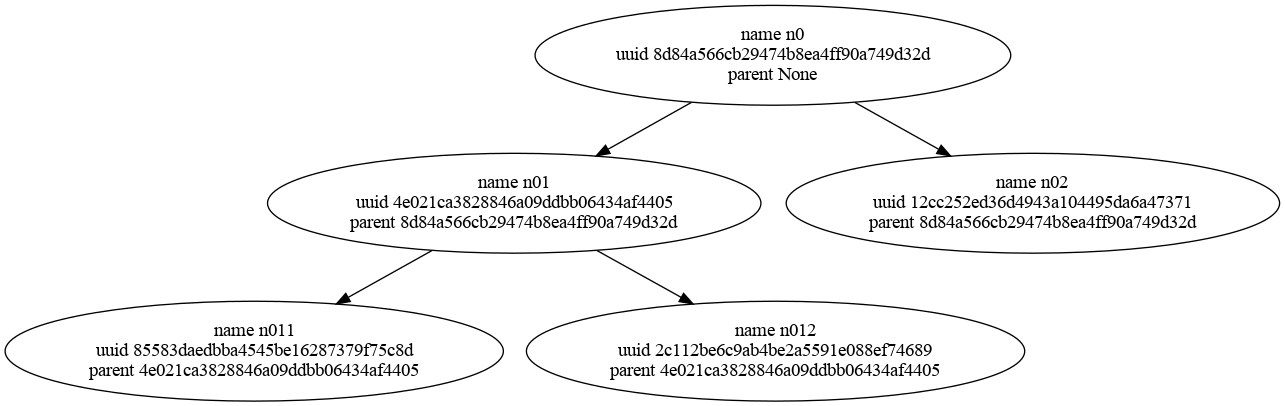

In [14]:
draw(dotstr)


In [15]:
db.visualize(path=ids)

'simple_graph.dot'

In [16]:
cat simple_graph.dot


digraph {
"8d84a566cb29474b8ea4ff90a749d32d" [label="name n0\nuuid 8d84a566cb29474b8ea4ff90a749d32d\nparent None"];
"4e021ca3828846a09ddbb06434af4405" [label="name n01\nuuid 4e021ca3828846a09ddbb06434af4405\nparent 8d84a566cb29474b8ea4ff90a749d32d"];
"12cc252ed36d4943a104495da6a47371" [label="name n02\nuuid 12cc252ed36d4943a104495da6a47371\nparent 8d84a566cb29474b8ea4ff90a749d32d"];
"85583daedbba4545be16287379f75c8d" [label="name n011\nuuid 85583daedbba4545be16287379f75c8d\nparent 4e021ca3828846a09ddbb06434af4405"];
"2c112be6c9ab4be2a5591e088ef74689" [label="name n012\nuuid 2c112be6c9ab4be2a5591e088ef74689\nparent 4e021ca3828846a09ddbb06434af4405"];
"8d84a566cb29474b8ea4ff90a749d32d" -> "4e021ca3828846a09ddbb06434af4405" [label="parent 8d84a566cb29474b8ea4ff90a749d32d"];
}


In [17]:
db.find_neighbors(n01.uuid)

[('4e021ca3828846a09ddbb06434af4405',
  '85583daedbba4545be16287379f75c8d',
  '{"parent":"4e021ca3828846a09ddbb06434af4405"}'),
 ('4e021ca3828846a09ddbb06434af4405',
  '2c112be6c9ab4be2a5591e088ef74689',
  '{"parent":"4e021ca3828846a09ddbb06434af4405"}'),
 ('8d84a566cb29474b8ea4ff90a749d32d',
  '4e021ca3828846a09ddbb06434af4405',
  '{"parent":"8d84a566cb29474b8ea4ff90a749d32d"}')]

In [18]:
db.find_neighbors(n02.uuid)

[('8d84a566cb29474b8ea4ff90a749d32d',
  '12cc252ed36d4943a104495da6a47371',
  '{"parent":"8d84a566cb29474b8ea4ff90a749d32d"}')]

In [19]:
db.remove_node(n011.uuid)

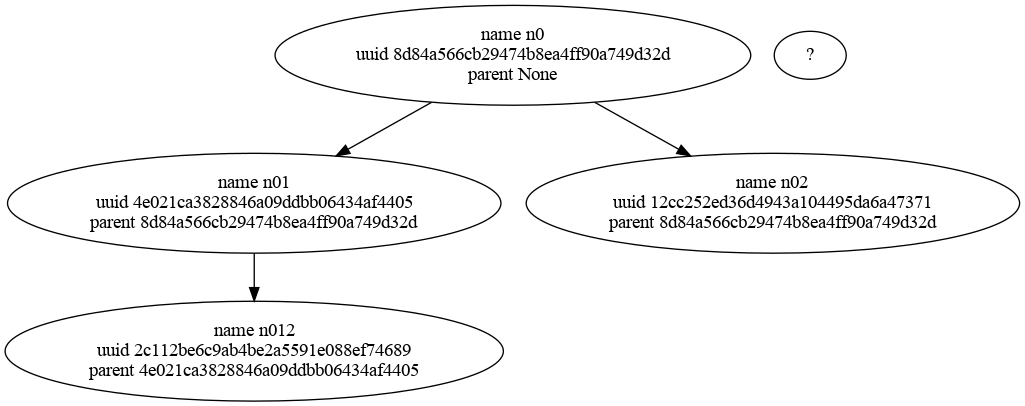

In [20]:
dotstr = db.get_dot(path=ids)
draw(dotstr)